In [4]:
import sys
paths_to_add = ["/homes/vk223/ProjectFlood", "/home/vkhandekar/project_flood"]
for p in paths_to_add:
    if p not in sys.path:
        sys.path.append(p)
print(sys.path)
import tarfile
import imageio.v2 as imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

import numpy as np
import pandas as pd
import time
import os
# os.chdir('/home/vkhandekar/project_flood')
import json
import random
import matplotlib.pyplot as plt
from matplotlib import colors
from data_extraction.generic_helpers import *
from dataloaders.custom_image_transforms import *


['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/vol/bitbucket/vk223/project_flood/projectfloodvenv/lib/python3.10/site-packages', '/homes/vk223/ProjectFlood', '/home/vkhandekar/project_flood']


In [5]:
# def get_rainfall_stats(rainfall_path: str):
#     minimum, maximum = 0.0, 0.0
    
#     for i in os.listdir(rainfall_path):
#         im = imageio.imread(os.path.join(rainfall_path, i))
#         maximum = max(maximum, np.max(im))
#         minimum = min(minimum, np.min(im))

#     return minimum, maximum

# min, max = get_rainfall_stats("data/BangladeshRainfall")
# print(min, max)

In [12]:
def get_log_rainfall_stats_training(training_path: str, rainfall_dir: str, preceding_rainfall_days: int, forecast_rainfall_days: int = 1):
    minimum, maximum = 0.0, 0.0
    
    for im in os.listdir(training_path):
        date_str = im[15:-4]
        date = pd.to_datetime(date_str, format=r"%Y%m%d")
        
        rainfall_dates = generate_timestamps(date, preceding_rainfall_days, forecast_rainfall_days, "3h")
        for rd in rainfall_dates:
            rain_image_name = os.path.join(rainfall_dir, rd.strftime(r"%Y%j.%H")+".tif")
            rain_image = imageio.imread(rain_image_name)
            rain_image = rain_image.astype(np.float32) # De quantize
            rain_image /= 1000.0
            rain_image = np.log(rain_image + 1) #Take log
            maximum = np.maximum(maximum, np.max(rain_image))
            minimum = np.minimum(minimum, np.min(rain_image))

    return minimum, maximum
# with open(os.environ["PROJECT_FLOOD_DATA"]) as config_file:
with open('/homes/vk223/ProjectFlood/static/imperial_data_paths.json') as config_file:  
    config = json.load(config_file)
min, max = get_log_rainfall_stats_training(f"{config['training_labels_path']}_256_256", f"{config['rainfall_path']}_256_256", 1)
print(min, max)


/tmp/ipykernel_3398244/1814358368.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rain_image /= 1000.0
/tmp/ipykernel_3398244/1814358368.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rain_image = np.log(rain_image + 1) #Take log


0.0 4.1972017


In [ ]:
min, max = get_log_rainfall_stats_training("/home/vkhandekar/project_flood/data/BangladeshWaterImagesTraining_256_256", "/home/vkhandekar/project_flood/data/BangladeshRainfall_256_256", 7)
print(min, max)

0.0 4.197201728820801


In [13]:

def normalise_rainfall(image, min, max):
    return (image - min)/(max - min)

def standardise_locally(image, thres_roi = 1.0):
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2
    

# def generate_image_label_sets(water_image_dir, soil_moisture_dir, topology_dir, rainfall_dir, rainfall_min, rainfall_max, preceding_rainfall_days):
#     images = []
#     labels = []

#     for im in sorted(os.listdir(water_image_dir)):
#         # Get 'label' i.e. the water inundation image
#         label_name = os.path.join(water_image_dir, im)
#         label = imageio.imread(label_name)
#         labels.append(label)

#         # Get 'conditioning' images and collate into a dictionary
#         images_dict = {}
#         date_str = im[15:-4]
#         date = pd.to_datetime(date_str, format=r"%Y%m%d")

#         #Topology - standardisation
#         topology_name = os.path.join(topology_dir, "BangladeshTopology.tif")
#         images_dict['topology'] = imageio.read(topology_name) #standardise: mid height regions can still be of importance

#         #Soil Moisture - pseudo min-max scaling
#         soil_moisture_date = date - pd.Timedelta(days=1)
#         soil_moisture_name = os.path.join(soil_moisture_dir, 
#                                             "BangladeshSoilMoisture" + soil_moisture_date.strftime(r"%Y%m%d") + ".tif")
#         soil_moisture_image = imageio.imread(soil_moisture_name)
#         soil_moisture_image = np.clip(soil_moisture_image, 0, 1) # pseudo-mix-max-scaling!
#         # images_dict['soil_moisture'] = imageio.imread(soil_moisture_name)
#         images_dict['soil_moisture'] = soil_moisture_image

#         #Rainfall - log min-max scaling
#         rainfall_dates = generate_timestamps(date, preceding_rainfall_days, 1, "3h")
#         preceding = []
#         forecast = []
#         for rd in rainfall_dates:
#             rain_image_name = os.path.join(rainfall_dir, rd.strftime(r"%Y%j.%H")+".tif")
#             rain_image = imageio.imread(rain_image_name)
#             rain_image = rain_image.astype(np.float32) # De quantize
#             rain_image /= 1000.0
#             rain_image = normalise_rainfall(rain_image, rainfall_min, rainfall_max)
#             if rd < date:
#                 preceding.append(rain_image)
#             else:
#                 forecast.append(rain_image)
        
#         images_dict['preceding'] = preceding
#         images_dict['forecast'] = forecast
        
#         images.append(images_dict)
#     return images, labels


def generate_label_images(label_name, soil_moisture_dir, topology_dir, rainfall_dir, rainfall_min, rainfall_max, preceding_rainfall_days, forecast_rainfall_days = 1):

    # Get 'conditioning' images and collate into a dictionary
    # Extract date from file path
    images_dict = {}
    print(label_name)
    date_str = label_name[15:-4]
    date = pd.to_datetime(date_str, format=r"%Y%m%d")

    #Topology - standardisation
    topology_name = os.path.join(topology_dir, "BangladeshTopology.tif")
    # images_dict['topology'] = imageio.imread(topology_name).toTensor()
    topology_image = imageio.imread(topology_name)
    topology_image = standardise_locally(topology_image)
    images_dict['topology'] = [topology_image]

    #Soil Moisture - pseudo min-max scaling
    soil_moisture_date = date - pd.Timedelta(days=1)
    soil_moisture_name = os.path.join(soil_moisture_dir, 
                                        "BangladeshSoilMoisture" + soil_moisture_date.strftime(r"%Y%m%d") + ".tif")
    soil_moisture_image = imageio.imread(soil_moisture_name)
    soil_moisture_image = np.clip(soil_moisture_image, 0, 1) # pseudo-mix-max-scaling!
    images_dict['soil_moisture'] = [soil_moisture_image]

    #Rainfall - log min-max scaling
    rainfall_dates = generate_timestamps(date, preceding_rainfall_days, forecast_rainfall_days, "3h")
    preceding = []
    forecast = []
    for rd in rainfall_dates:
        rain_image_name = os.path.join(rainfall_dir, rd.strftime(r"%Y%j.%H")+".tif")
        rain_image = imageio.imread(rain_image_name)
        rain_image = rain_image.astype(np.float32) # De quantize
        rain_image /= 1000.0
        rain_image = normalise_rainfall(rain_image, rainfall_min, rainfall_max)
        if rd < date:
            preceding.append(rain_image)
        else:
            forecast.append(rain_image)
    
    images_dict['preceding'] = preceding
    images_dict['forecast'] = forecast
    
    return images_dict

In [14]:
#Define the transformation
train_transform = Compose([
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    RandomRotation(180),
])

In [15]:
def prepare_tensors(tensor_list):
    if len(tensor_list) > 1:
        # Stack if there's more than one tensor
        return torch.stack(tensor_list, dim=0)
    else:
        # Add a dimension to make it [1, X, Y] if there's only one tensor
        return tensor_list[0].unsqueeze(0)

In [16]:
class FloodPredictionDataset(Dataset):
    def __init__(self, config_file_path, label_file_name, resolution, preceding_rainfall_days, forecast_rainfall_days, transform=None):
        with open(config_file_path) as config_file:
            config = json.load(config_file)
            
        self.rainfall_dir = f"{config['rainfall_path']}_{resolution}_{resolution}"
        self.topology_dir = f"{config['topology_path']}_{resolution}_{resolution}"
        self.soil_moisture_combo_dir = f"{config['soil_moisture_combo_path']}_{resolution}_{resolution}"
        self.water_images_dir = f"{config[label_file_name]}_{resolution}_{resolution}"
        # self.topology_dir = config['topology_path']
        # self.soil_moisture_flood_dir = config['soil_moisture_flood_path']
        # self.soil_moisture_non_flood_dir = config['soil_moisture_non_flood_path']
        # self.soil_moisture_combo_dir = config['soil_moisture_combo_path']
        # self.flood_images_dir = config['flood_file_path']
        # self.non_flood_images_dir = config['non_flood_file_path']
        # self.water_images_dir = config['water_images_file_path']
        self.preceding_rainfall_days = preceding_rainfall_days
        self.forecast_rainfall_days = forecast_rainfall_days
        self.transform = transform
        self.resolution = resolution

        self.rainfall_min, self.rainfall_max = get_log_rainfall_stats_training(f"{config['training_labels_path']}_{self.resolution}_{self.resolution}", 
                                                                               self.rainfall_dir,
                                                                               self.preceding_rainfall_days)
        
    def __len__(self):
        return len(os.listdir(self.water_images_dir))

    def __getitem__(self, idx):

        label_name = sorted(os.listdir(self.water_images_dir))[idx]
        print(os.path.join(self.water_images_dir, label_name))
        label = imageio.imread(os.path.join(self.water_images_dir, label_name))
        print(label.dtype)

        # Get images, transform each if needed, then combine into a single tensor
        images = generate_label_images(label_name, 
                                       self.soil_moisture_combo_dir, 
                                       self.topology_dir, 
                                       self.rainfall_dir, 
                                       self.rainfall_min, 
                                       self.rainfall_max, 
                                       self.preceding_rainfall_days)
        
        # Convert images to tensors
        label_tensor = torch.tensor(label)
        image_tensors = {}
        for key, value in images.items():
            tensor_images = [torch.tensor(image, dtype=torch.float32) for image in value]
            image_tensors[key] = tensor_images
        
        if self.transform:
            image_tensors, label_tensor = self.transform(image_tensors, label_tensor)

        preceding_stacked = prepare_tensors(image_tensors['preceding'])
        forecast_stacked = prepare_tensors(image_tensors['forecast'])
        soil_moisture_stacked = prepare_tensors(image_tensors['soil_moisture'])
        topology_stacked = prepare_tensors(image_tensors['topology'])

        image_tensor = torch.cat([preceding_stacked, forecast_stacked, topology_stacked, soil_moisture_stacked], dim=0)
       
        
        return image_tensor, label_tensor


In [18]:
from torch.utils.data import DataLoader
from dataloaders.custom_image_transforms import *
# training_dataset = FloodPredictionDataset(os.environ["PROJECT_FLOOD_DATA"], "training_labels_path", 
#                                           resolution=256, 
#                                           preceding_rainfall_days=1, 
#                                           forecast_rainfall_days=1, 
#                                           transform=train_transform)
training_dataset = FloodPredictionDataset('/homes/vk223/ProjectFlood/static/imperial_data_paths.json', "training_labels_path", 
                                          resolution=256, 
                                          preceding_rainfall_days=1, 
                                          forecast_rainfall_days=1, 
                                          transform=train_transform)
batch_size = 16
training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=4)


/tmp/ipykernel_3398244/1814358368.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rain_image /= 1000.0
/tmp/ipykernel_3398244/1814358368.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rain_image = np.log(rain_image + 1) #Take log


/vol/bitbucket/vk223/project_flood/data/BangladeshWaterImagesTraining_256_256/BangladeshWater20000918.tif
uint8
BangladeshWater20000918.tif


/tmp/ipykernel_3398244/87622571.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  roi = (image >= val_l)
/tmp/ipykernel_3398244/87622571.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  image2 = (image - mu) / (sigma + eps)
/tmp/ipykernel_3398244/87622571.py:95: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rain_image /= 1000.0
/tmp/ipykernel_3398244/87622571.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (image - min)/(max - min)


torch.Size([18, 256, 256])
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.uint8


In [19]:
a = training_dataset.__getitem__(0)
print(a[0][0].shape)
for i in a[0]:
    print(i.dtype)
print(a[1].dtype)

/vol/bitbucket/vk223/project_flood/data/BangladeshWaterImagesTraining_256_256/BangladeshWater20000918.tif
uint8
BangladeshWater20000918.tif
torch.Size([256, 256])
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.uint8


/tmp/ipykernel_3398244/87622571.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  roi = (image >= val_l)
/tmp/ipykernel_3398244/87622571.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  image2 = (image - mu) / (sigma + eps)
/tmp/ipykernel_3398244/87622571.py:95: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rain_image /= 1000.0
/tmp/ipykernel_3398244/87622571.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (image - min)/(max - min)


/vol/bitbucket/vk223/project_flood/data/BangladeshWaterImagesTraining_256_256/BangladeshWater20000918.tif
uint8
BangladeshWater20000918.tif


/tmp/ipykernel_3398244/87622571.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  roi = (image >= val_l)
/tmp/ipykernel_3398244/87622571.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  image2 = (image - mu) / (sigma + eps)
/tmp/ipykernel_3398244/87622571.py:95: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rain_image /= 1000.0
/tmp/ipykernel_3398244/87622571.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (image - min)/(max - min)


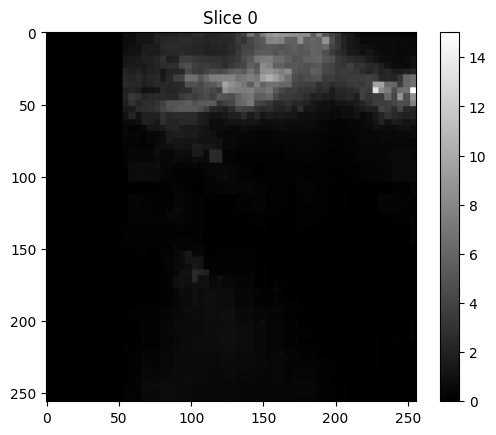

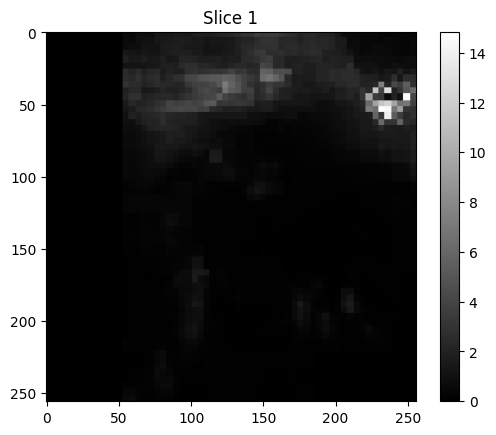

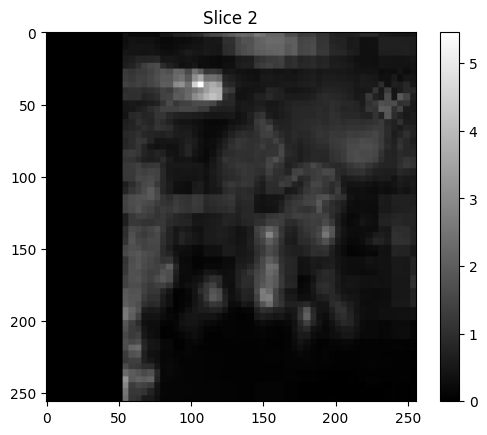

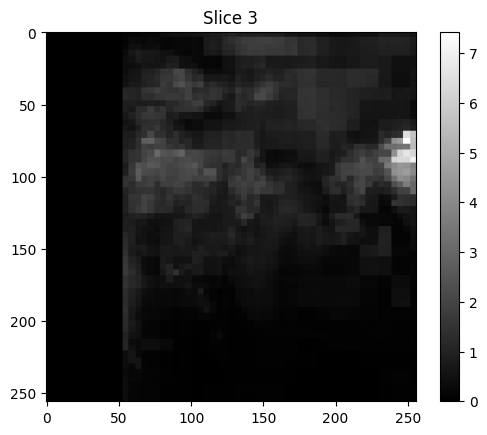

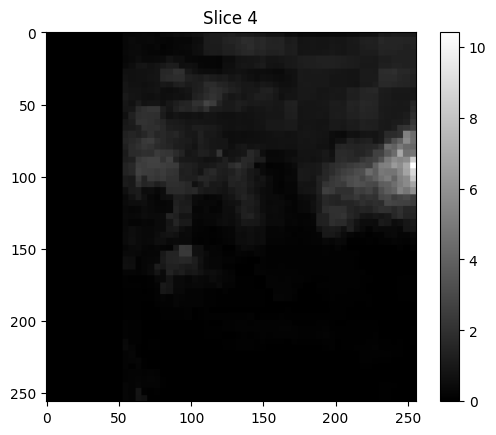

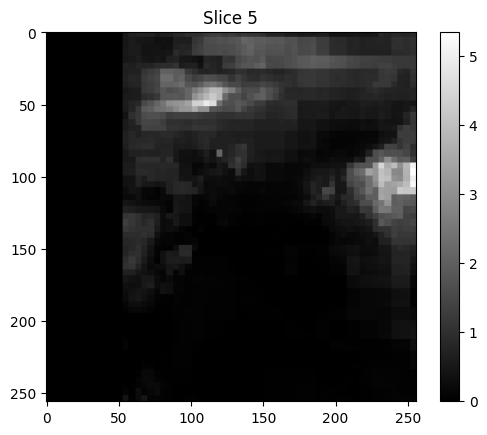

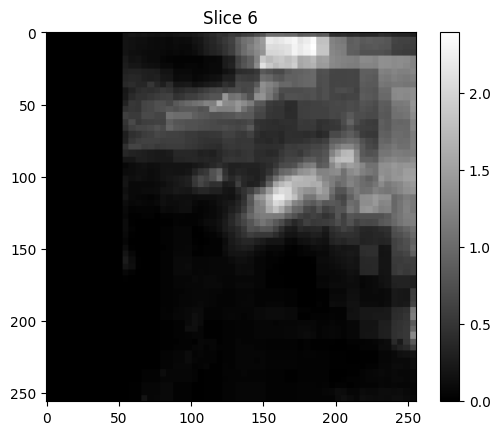

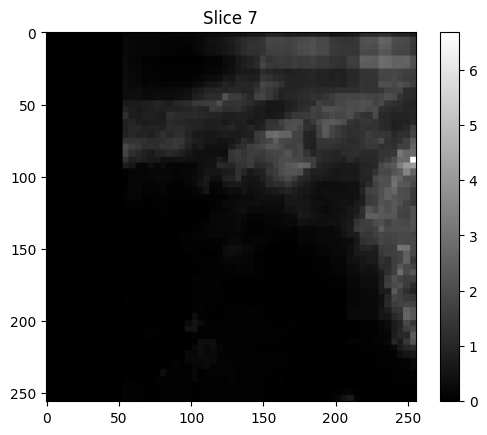

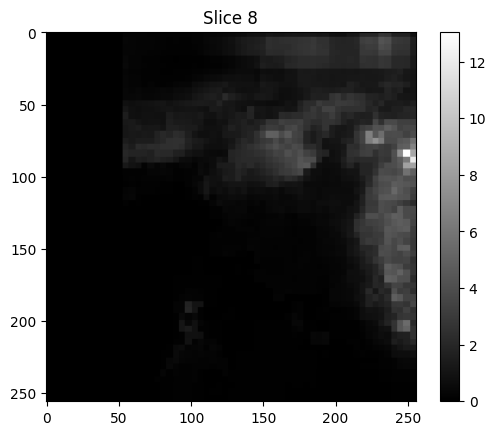

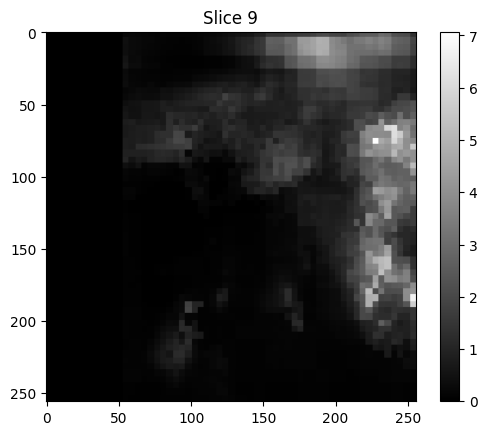

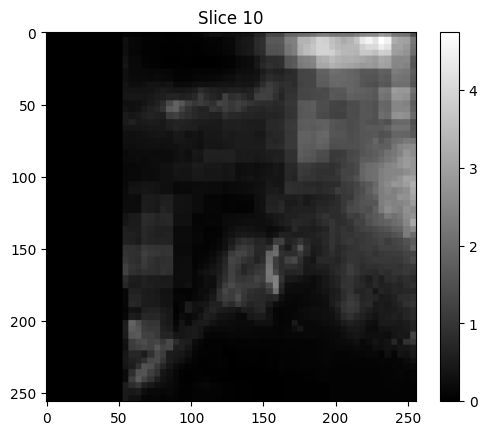

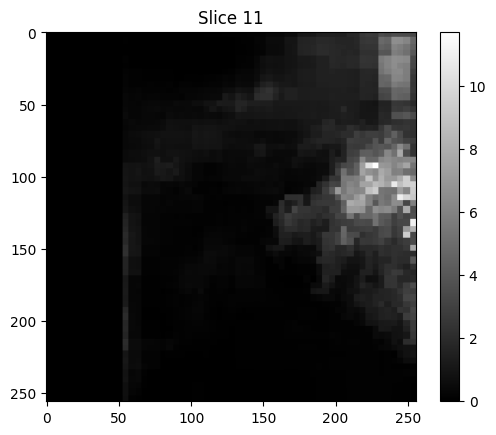

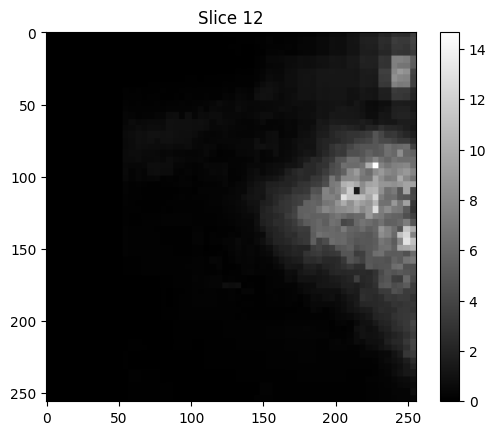

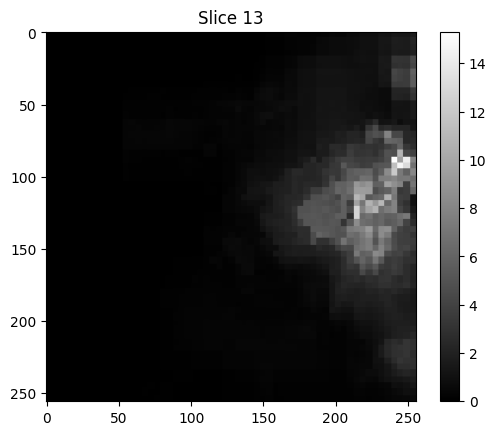

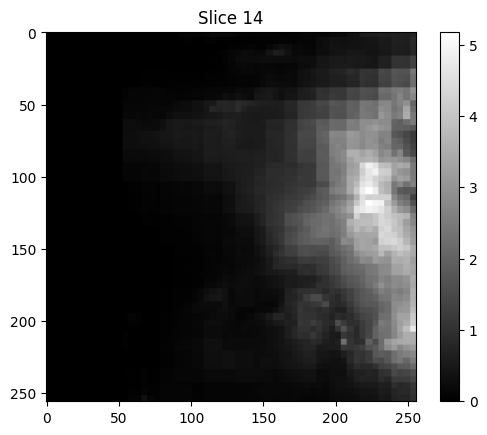

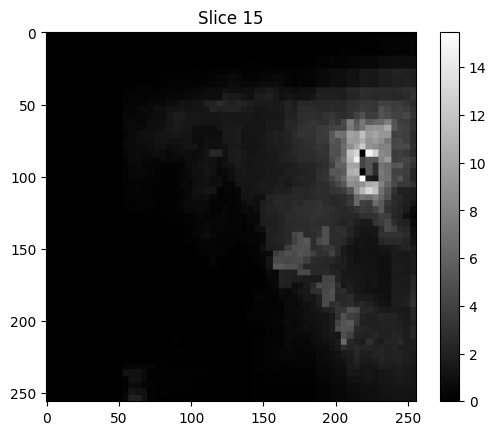

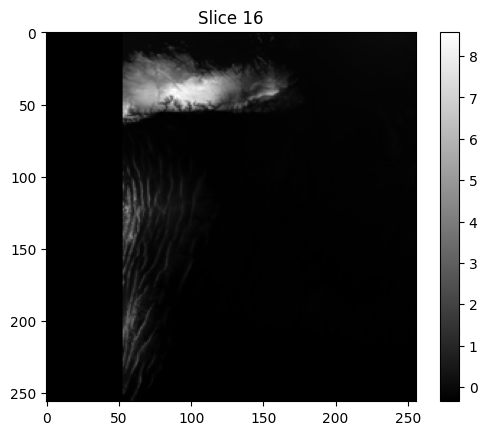

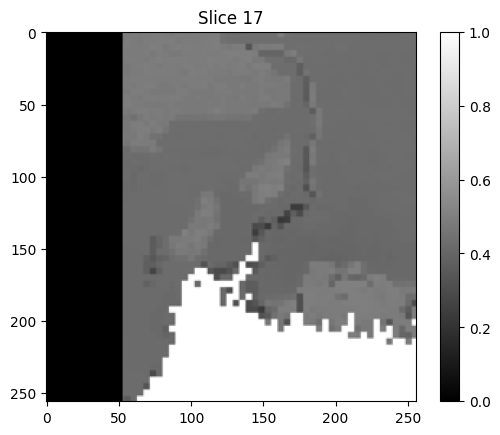

In [22]:
import matplotlib.pyplot as plt

# Assume 'a' is a 3D tensor with shape [n, height, width]
a = training_dataset.__getitem__(0)[0]
n = a.shape[0]  # Number of 2D slices

for i in range(n):
    plt.imshow(a[i].numpy(), cmap='gray')  # Convert to numpy array and use grayscale
    plt.title(f'Slice {i}')
    plt.colorbar()  # Optionally add a color bar
    plt.show()